In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")

In [2]:
print("Not running in Colab")
IN_COLAB = False

Not running in Colab


In [3]:
import os
from pathlib import Path
import shutil
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import joblib

In [4]:
if IN_COLAB:
    BASE_DRIVE = Path("/content/drive/MyDrive")
else:
    BASE_DRIVE = Path.home() / "Desktop" / "Mechatronics_Fundamentals_Project" / "HandMimic_Dataset_Local"

DRIVE_DATASET_PATH = BASE_DRIVE / "HandMimic_Dataset"
MP_OUTPUT_PATH = BASE_DRIVE / "HandMimic_Landmarks_Val"
os.makedirs(DRIVE_DATASET_PATH, exist_ok=True)
os.makedirs(MP_OUTPUT_PATH, exist_ok=True)

print("Dataset path:", DRIVE_DATASET_PATH)
print("Mediapipe output path:", MP_OUTPUT_PATH)

Dataset path: C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Dataset
Mediapipe output path: C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Landmarks_Val


In [5]:
KAGGLE_JSON_PATH = BASE_DRIVE / "kaggle.json"

kaggle_ok = False
if KAGGLE_JSON_PATH.exists():
    kaggle_dir = Path.home() / ".kaggle"
    kaggle_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy2(KAGGLE_JSON_PATH, kaggle_dir / "kaggle.json")
    os.chmod(kaggle_dir / "kaggle.json", 0o600)
    kaggle_ok = True
    print("Found kaggle.json and copied to ~/.kaggle/kaggle.json")
else:
    if os.environ.get("KAGGLE_USERNAME") and os.environ.get("KAGGLE_KEY"):
        kaggle_ok = True
        print("KAGGLE credentials found in environment variables.")
    else:
        print("No kaggle.json found and no KAGGLE_* env vars. Skipping Kaggle download.")
        print("If you want to download automatically, place kaggle.json in", KAGGLE_JSON_PATH, 
              "or set environment variables KAGGLE_USERNAME & KAGGLE_KEY.")

Found kaggle.json and copied to ~/.kaggle/kaggle.json


In [6]:
DATASET_ZIP_PATH = DRIVE_DATASET_PATH / "hand-gesture-detection-system.zip"
if kaggle_ok and not DATASET_ZIP_PATH.exists():
    print("Downloading dataset from Kaggle...")
    kaggle_cmd = f"kaggle datasets download -d marusagar/hand-gesture-detection-system -p {DRIVE_DATASET_PATH} --force"
    download_result = os.system(kaggle_cmd)
    if download_result != 0:
        print("Warning: kaggle download returned non-zero status. Check credentials and dataset slug.")
    else:
        print("Download complete.")
else:
    if DATASET_ZIP_PATH.exists():
        print("Dataset zip already exists, skipping download.")
    else:
        print("Kaggle download skipped (no credentials or already present). If you have dataset zip, place it at:", DATASET_ZIP_PATH)

Dataset zip already exists, skipping download.


In [7]:
EXTRACTED_DIR = DRIVE_DATASET_PATH / "extracted"
if DATASET_ZIP_PATH.exists() and not EXTRACTED_DIR.exists():
    print("Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zf:
        zf.extractall(EXTRACTED_DIR)
    print("Extraction done.")
else:
    if EXTRACTED_DIR.exists():
        print("Dataset already extracted at", EXTRACTED_DIR)
    else:
        print("No dataset zip to extract. Make sure dataset is available in", DATASET_ZIP_PATH)

Dataset already extracted at C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Dataset\extracted


In [8]:
VAL_CSV_PATH = EXTRACTED_DIR / "val.csv"
VAL_IMAGES_PATH = EXTRACTED_DIR / "val" / "val"

print("Expecting val csv at:", VAL_CSV_PATH)
print("Expecting val images dir at:", VAL_IMAGES_PATH)

Expecting val csv at: C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Dataset\extracted\val.csv
Expecting val images dir at: C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Dataset\extracted\val\val


In [9]:
def robust_read_csv(path):
    if not path.exists():
        raise FileNotFoundError(f"CSV not found: {path}")
    try:
        df = pd.read_csv(path, header=None, sep=';')
        if df.shape[1] <= 1:
            raise ValueError
    except Exception:
        df = pd.read_csv(path, header=None, sep=',')
    return df
  
try:
    val_df = robust_read_csv(VAL_CSV_PATH)
    val_df.columns = ['Image Name', 'Gesture', 'Classification']
    print("Val CSVs read successfully. Val rows:", len(val_df))
except Exception as e:
    print("Error reading CSVs:", e)
    val_df = pd.DataFrame(columns=['Image Name','Gesture','Classification'])

Val CSVs read successfully. Val rows: 100


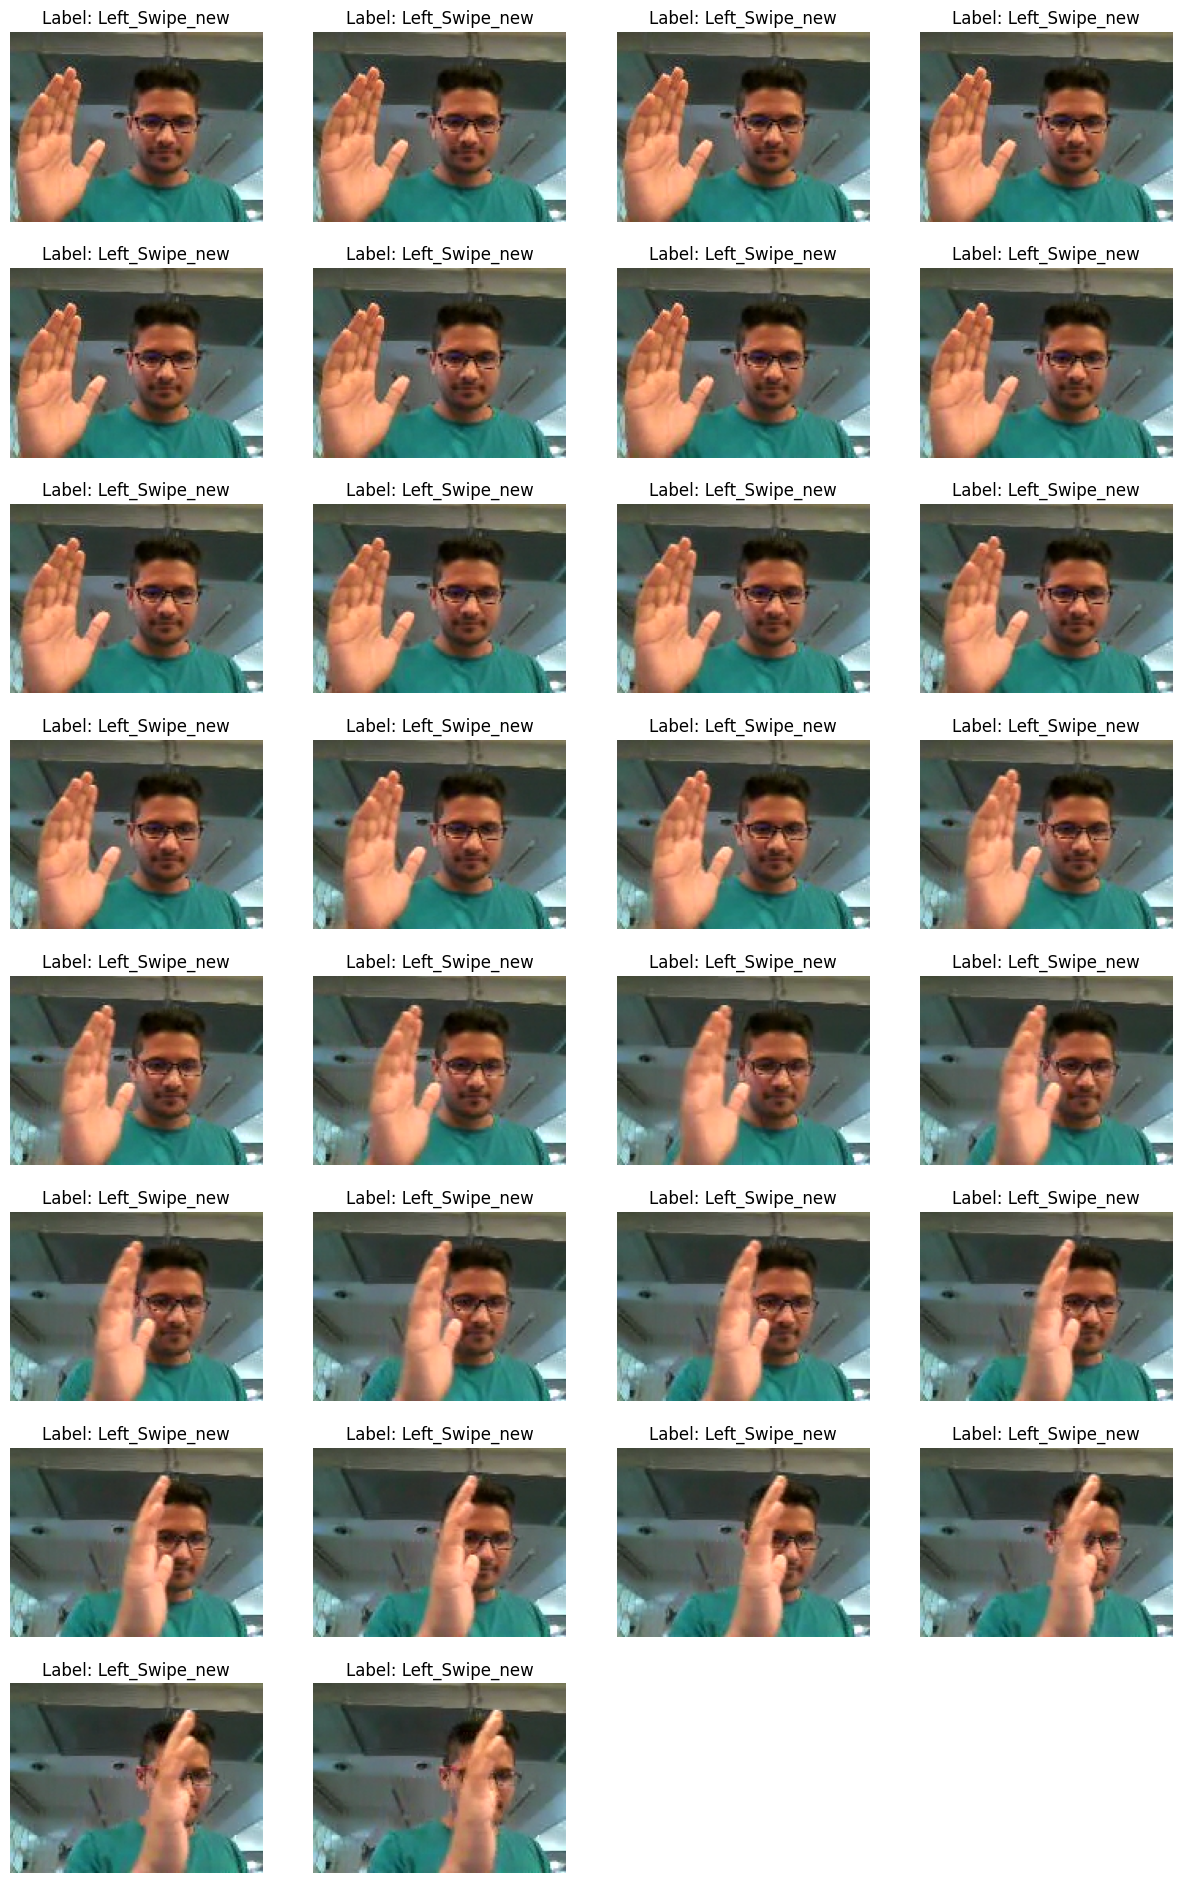

In [10]:
def list_images_for_gesture(images_root: Path, gesture_folder_name: str):
    folder = images_root / gesture_folder_name
    if not folder.exists():
        return []
    return sorted([str(p) for p in folder.iterdir() if p.suffix.lower() in {'.jpg','.jpeg','.png'}])

sample_image_paths = []
if len(val_df) > 0:
    first_gesture_row = val_df.iloc[0]
    gesture_folder = first_gesture_row['Image Name']
    sample_image_paths = list_images_for_gesture(VAL_IMAGES_PATH, gesture_folder)
else:
    if VAL_IMAGES_PATH.exists():
        for root, dirs, files in os.walk(VAL_IMAGES_PATH):
            for f in files:
                if f.lower().endswith(('.jpg','.jpeg','.png')):
                    sample_image_paths.append(os.path.join(root, f))
            break

if sample_image_paths:
    cols = 4
    rows = (len(sample_image_paths) + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3))
    for i, p in enumerate(sample_image_paths):
        img = cv2.imread(p)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img_rgb)
        lbl = first_gesture_row['Gesture'] if len(val_df)>0 else os.path.basename(os.path.dirname(p))
        plt.title(f"Label: {lbl}")
        plt.axis('off')
    plt.show()
else:
    print("No sample images found to display. Check VAL_IMAGES_PATH:", VAL_IMAGES_PATH)

In [11]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

landmarks_csv_path = MP_OUTPUT_PATH / "hand_landmarks.csv"

landmark_cols = []
for i in range(21):
    landmark_cols += [f"landmark_{i}_x", f"landmark_{i}_y", f"landmark_{i}_z"]

columns = ["folder_name", "image_name", "label", "has_hand"] + landmark_cols

def process_images_and_save_landmarks(image_paths_list,
                                      out_csv_path=landmarks_csv_path,
                                      val_df=None,
                                      force_recompute=False,
                                      min_detection_confidence=0.5):
    out_csv_path = Path(out_csv_path)
    processed_set = set()
    existing_df = None
    if out_csv_path.exists() and not force_recompute:
        try:
            existing_df = pd.read_csv(out_csv_path)
            if 'folder_name' in existing_df.columns and 'image_name' in existing_df.columns:
                processed_set = set(zip(existing_df['folder_name'].astype(str), existing_df['image_name'].astype(str)))
            else:
                processed_set = set()
            print(f"Found existing annotated CSV with {len(existing_df)} rows. Will skip already-processed images.")
        except Exception as e:
            print("Warning: couldn't read existing CSV. Will re-generate. Error:", e)
            existing_df = None
            processed_set = set()
    else:
        if out_csv_path.exists() and force_recompute:
            print("force_recompute=True -> existing annotated CSV will be overwritten after processing new run.")
        else:
            print("No existing annotated CSV found. A new one will be created.")

    rows = []
    count_skipped = 0
    count_processed = 0

    image_paths_list = [str(p) for p in image_paths_list]
    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=min_detection_confidence) as hands:
        for img_path in tqdm(image_paths_list, desc="Processing images"):
            try:
                p = Path(img_path)
                folder_name = p.parent.name
                image_name = p.name

                if not force_recompute and (folder_name, image_name) in processed_set:
                    count_skipped += 1
                    continue

                img = cv2.imread(str(p))
                if img is None:
                    continue
                h, w = img.shape[:2]
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                results = hands.process(img_rgb)
                
                row = {
                    "folder_name": folder_name,
                    "image_name": image_name,
                    "label": None,
                    "has_hand": False
                }
                for c in landmark_cols:
                    row[c] = np.nan

                if val_df is not None:
                    try:
                        match = val_df[val_df['Image Name'] == folder_name]
                        if len(match) > 0:
                            row['label'] = match.iloc[0]['Gesture']
                    except Exception:
                        row['label'] = None

                if results and getattr(results, "multi_hand_landmarks", None):
                    if results.multi_hand_landmarks:
                        hand_landmarks = results.multi_hand_landmarks[0]
                        row["has_hand"] = True
                        for i, lm in enumerate(hand_landmarks.landmark):
                            row[f"landmark_{i}_x"] = float(lm.x)
                            row[f"landmark_{i}_y"] = float(lm.y)
                            row[f"landmark_{i}_z"] = float(lm.z)

                rows.append(row)
                count_processed += 1

            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    df_new = pd.DataFrame(rows, columns=columns)

    if existing_df is not None and not force_recompute:
        try:
            existing_df_clean = existing_df.dropna(axis=1, how='all')
            df_new_clean = df_new.dropna(axis=1, how='all')
            df_all = pd.concat([existing_df_clean, df_new_clean], ignore_index=True)
        except Exception as e:
            print("Warning while concatenating existing and new df:", e)
            df_all = df_new
    else:
        df_all = df_new

    out_csv_path.parent.mkdir(parents=True, exist_ok=True)
    df_all.to_csv(out_csv_path, index=False)
    print(f"Saved landmarks to {out_csv_path}  (new processed: {count_processed}, skipped: {count_skipped}, total rows: {len(df_all)})")
    return out_csv_path

all_val_image_paths = []
if VAL_IMAGES_PATH.exists():
    for root, dirs, files in os.walk(VAL_IMAGES_PATH):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_val_image_paths.append(os.path.join(root, f))
else:
    print("VAL_IMAGES_PATH does not exist; no images to process.")

if all_val_image_paths:
    process_images_and_save_landmarks(all_val_image_paths,
                                      out_csv_path=landmarks_csv_path,
                                      val_df=(val_df if 'val_df' in globals() else None),
                                      force_recompute=False)
else:
    print("No images found to process.")

Found existing annotated CSV with 3000 rows. Will skip already-processed images.


Processing images: 100%|██████████| 3000/3000 [00:00<00:00, 28588.63it/s]


Saved landmarks to C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Landmarks_Val\hand_landmarks.csv  (new processed: 0, skipped: 3000, total rows: 3000)


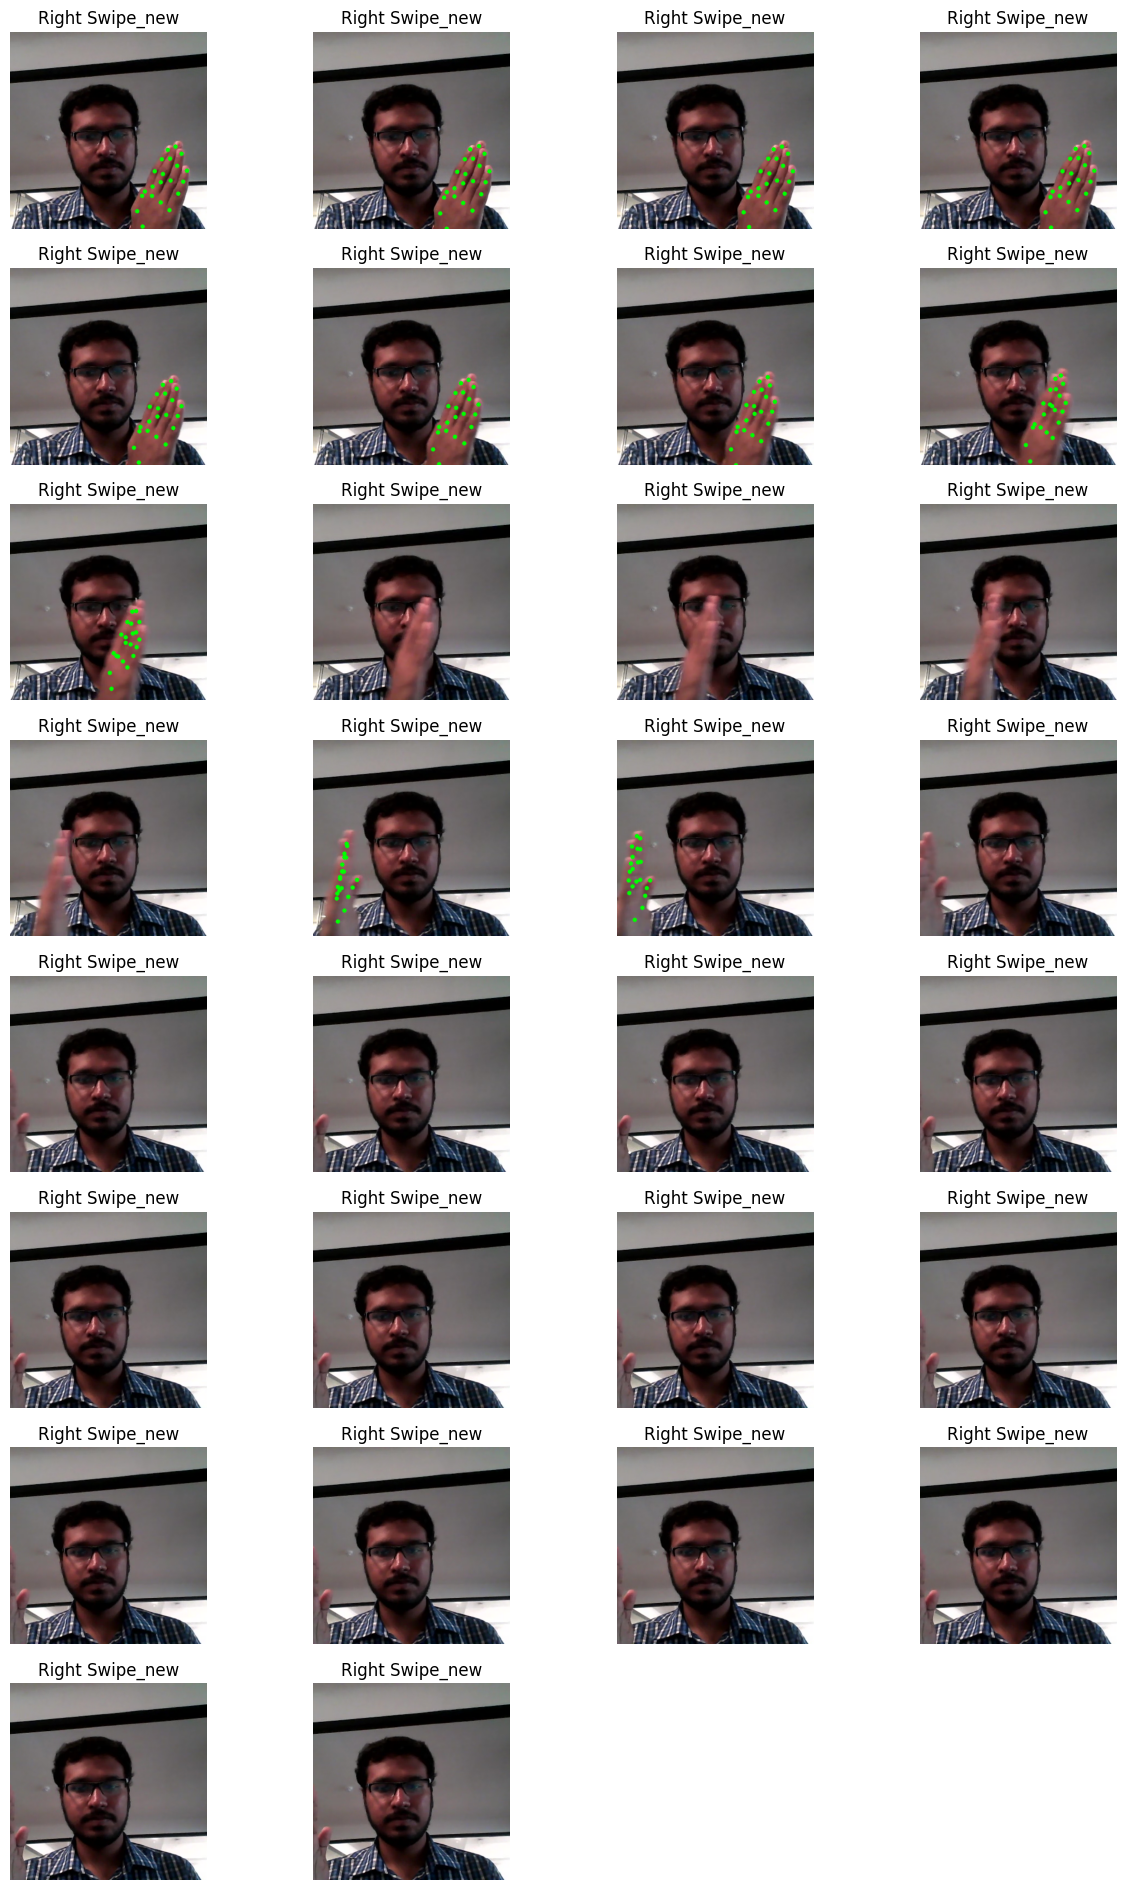

In [12]:
def plot_landmarks_from_csv(csv_path, images_base_path):
    df = pd.read_csv(csv_path)

    first_folder = df['folder_name'].iloc[0]
    subset = df[df['folder_name'] == first_folder]

    plt.figure(figsize=(15, (len(subset)//4 + 1) * 3))

    for idx, row in enumerate(subset.itertuples()):
        img_path = Path(images_base_path) / row.folder_name / row.image_name
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if row.has_hand:
            for i in range(21):
                x = getattr(row, f"landmark_{i}_x", np.nan)
                y = getattr(row, f"landmark_{i}_y", np.nan)
                if not np.isnan(x) and not np.isnan(y):
                    h, w = img_rgb.shape[:2]
                    px, py = int(x * w), int(y * h)
                    cv2.circle(img_rgb, (px, py), 4, (0, 255, 0), -1)

        plt.subplot((len(subset)+3)//4, 4, idx+1)
        plt.imshow(img_rgb)
        plt.title(f"{row.label if row.label else 'Unknown'}")
        plt.axis('off')

    plt.show()

plot_landmarks_from_csv(csv_path=landmarks_csv_path, images_base_path=VAL_IMAGES_PATH)

In [13]:
WINDOW_SIZE = 5
MIN_HAND_DETECTED_RATIO = 0.5

landmarks_groups_csv_path = MP_OUTPUT_PATH / "hand_landmarks_groups.csv"

FEATURE_COLS = [
    # Static features
    "thumb_angle",
    "index_angle",
    "middle_angle",
    "ring_angle",
    "pinky_angle",
    "thumb_index_distance",
    "hand_center_x",
    "hand_center_y",
    "hand_center_z",
    "hand_width",
    "hand_height",
    "num_fingers_up",
    # Dynamic features
    "move_dx",
    "move_dy",
    "move_dz",
    "move_distance",
    "move_ratio_xy",
    "move_angle_xy",
    "move_angle_yz"
]

df_landmarks = pd.read_csv(landmarks_csv_path)

image_cols = [f"image_{i+1}" for i in range(WINDOW_SIZE)]
group_columns = ["folder_name"] + image_cols + ["hand_detected", "label"] + FEATURE_COLS

if landmarks_groups_csv_path.exists():
    df_groups_out = pd.read_csv(landmarks_groups_csv_path)
    existing_groups = set(tuple(row[image_cols]) for _, row in df_groups_out.iterrows())
else:
    df_groups_out = pd.DataFrame(columns=group_columns)
    existing_groups = set()

rows_out = []

for folder_name, df_folder in df_landmarks.groupby("folder_name"):
    df_folder = df_folder.reset_index(drop=True)
    n_rows = len(df_folder)
    
    for start_idx in range(n_rows - WINDOW_SIZE + 1):
        window = df_folder.iloc[start_idx:start_idx + WINDOW_SIZE]
        image_names = list(window["image_name"])
        
        if tuple(image_names) in existing_groups:
            continue
        
        hand_flags = window["has_hand"].astype(bool).values
        hand_detected = hand_flags.sum() >= (WINDOW_SIZE * MIN_HAND_DETECTED_RATIO)
        
        labels = window["label"].dropna()
        label = labels.mode()[0] if len(labels) > 0 else None
        
        features = {f: np.nan for f in FEATURE_COLS}
        
        if hand_detected:
            lm_cols = [f"landmark_{i}_{axis}" for i in range(21) for axis in ["x","y","z"]]
            lm_data = window[lm_cols].values.reshape(WINDOW_SIZE, 21, 3)
            
            # indices of frames with hand
            hand_indices = np.where(hand_flags)[0]
            
            if len(hand_indices) > 0:
                # ---- Static features from middle frame with hand ----
                mid_idx = hand_indices[len(hand_indices)//2]
                lm_mid = lm_data[mid_idx]
                
                # Hand center
                hand_center = lm_mid.mean(axis=0)
                features["hand_center_x"] = hand_center[0]
                features["hand_center_y"] = hand_center[1]
                features["hand_center_z"] = hand_center[2]
                
                # Thumb angle
                thumb_vec = lm_mid[4] - lm_mid[0]
                features["thumb_angle"] = np.degrees(np.arctan2(thumb_vec[1], thumb_vec[0]))
                
                # Thumb-index distance
                features["thumb_index_distance"] = np.linalg.norm(lm_mid[4] - lm_mid[8])
                
                # Finger angles
                def finger_angle(start_idx, end_idx):
                    vec = lm_mid[end_idx] - lm_mid[start_idx]
                    return np.degrees(np.arctan2(vec[1], vec[0]))
                
                features["index_angle"] = finger_angle(5,8)
                features["middle_angle"] = finger_angle(9,12)
                features["ring_angle"] = finger_angle(13,16)
                features["pinky_angle"] = finger_angle(17,20)
                
                # Hand width/height
                features["hand_width"] = lm_mid[:,0].max() - lm_mid[:,0].min()
                features["hand_height"] = lm_mid[:,1].max() - lm_mid[:,1].min()
                
                # Fingers up
                count_up = 0
                for f_idx, pip_idx in zip([4,8,12,16,20],[2,6,10,14,18]):
                    if lm_mid[f_idx,1] < lm_mid[pip_idx,1]:
                        count_up += 1
                features["num_fingers_up"] = count_up
                
                # ---- Dynamic features from first and last frame with hand ----
                if len(hand_indices) > 1:
                    first_idx, last_idx = hand_indices[0], hand_indices[-1]
                    lm_first = lm_data[first_idx]
                    lm_last = lm_data[last_idx]
                    
                    center_first = lm_first.mean(axis=0)
                    center_last = lm_last.mean(axis=0)
                    
                    move_vec = center_last - center_first
                    features["move_dx"] = move_vec[0]
                    features["move_dy"] = move_vec[1]
                    features["move_dz"] = move_vec[2]
                    features["move_distance"] = np.linalg.norm(move_vec)
                    features["move_ratio_xy"] = abs(features["move_dx"]) / (abs(features["move_dy"]) + 1e-6)
                    features["move_angle_xy"] = np.degrees(np.arctan2(move_vec[1], move_vec[0]))
                    features["move_angle_yz"] = np.degrees(np.arctan2(move_vec[2], move_vec[1]))
        
        row = [folder_name] + image_names + [hand_detected, label] + [features[f] for f in FEATURE_COLS]
        rows_out.append(row)

if rows_out:
    df_new = pd.DataFrame(rows_out, columns=group_columns)
    df_groups_out_clean = df_groups_out.dropna(axis=1, how='all')
    df_new_clean = df_new.dropna(axis=1, how='all')
    df_groups_out = pd.concat([df_groups_out_clean, df_new_clean], ignore_index=True)
    df_groups_out.to_csv(landmarks_groups_csv_path, index=False)
    print(f"Saved {len(rows_out)} new frame groups to {landmarks_groups_csv_path}")
else:
    print("No new frame groups to add.")

No new frame groups to add.


In [14]:
df_detected = df_groups_out[df_groups_out["hand_detected"] == True].copy()
print(df_detected['label'].value_counts())

label
Stop_new                         344
Thumbs_Down_new                  276
Right_Swipe_new                  252
Left_Swipe_new                   235
Thumbs_Up_new                    216
Thumbs Down_new                  203
Stop Gesture_new                 197
Thumbs Up_new                    147
Right Swipe_new                  142
Left Swipe_new_Left Swipe_new     49
Name: count, dtype: int64


In [15]:
label_mapping = {
    "Stop_new": "Stop",
    "Stop Gesture_new": "Stop",
    "Thumbs_Up_new": "Thumbs Up",
    "Thumbs Up_new": "Thumbs Up",
    "Thumbs_Down_new": "Thumbs Down",
    "Thumbs Down_new": "Thumbs Down",
    "Left_Swipe_new": "Left Swipe",
    "Left Swipe_new_Left Swipe_new": "Left Swipe",
    "Right_Swipe_new": "Right Swipe",
    "Right Swipe_new": "Right Swipe"
}

df_detected['label'] = df_detected['label'].map(label_mapping)
print(df_detected['label'].value_counts())

label
Stop           541
Thumbs Down    479
Right Swipe    394
Thumbs Up      363
Left Swipe     284
Name: count, dtype: int64


In [16]:
SELECTED_FEATURE_COLS = [
    "thumb_angle",
    "index_angle",
    "middle_angle",
    "ring_angle",
    "pinky_angle",
    "thumb_index_distance",
    "hand_center_x",
    "hand_center_y",
    "hand_center_z",
    "hand_width",
    "hand_height",
    "num_fingers_up",
    "move_dx",
    "move_dy",
    "move_dz",
    "move_distance",
    "move_ratio_xy",
    "move_angle_xy",
    "move_angle_yz"
]

val_landmarks_csv = MP_OUTPUT_PATH / "hand_landmarks.csv"
val_groups_csv = MP_OUTPUT_PATH / "hand_landmarks_groups.csv"
val_predictions_csv = MP_OUTPUT_PATH / "predictions.csv"

encoder_path = BASE_DRIVE / "label_encoder.pkl"
scaler_path = BASE_DRIVE / "scaler.pkl"
model_path = BASE_DRIVE / "gesture_model.keras"

model_loaded = load_model(str(model_path))

if not model_path.exists() or not encoder_path.exists() or not scaler_path.exists():
    raise FileNotFoundError("gesture_model.keras or label_encoder.pkl or scaler.pkl not found in MP_OUTPUT_PATH")

label_encoder = joblib.load(encoder_path)
scaler = joblib.load(scaler_path)

In [17]:
X_pred = df_detected[FEATURE_COLS].values
X_pred = scaler.transform(X_pred)

y_pred_probs = model_loaded.predict(X_pred, verbose=0)
y_pred_encoded = np.argmax(y_pred_probs, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

df_detected["predicted_label"] = y_pred_labels
df_detected["predicted_confidence"] = y_pred_probs.max(axis=1)

df_detected.to_csv(val_predictions_csv, index=False)
print(f"Predictions saved to {val_predictions_csv}")

Predictions saved to C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Landmarks_Val\predictions.csv



Validation Accuracy: 0.9592

Classification Report:
              precision    recall  f1-score   support

  Left Swipe       0.93      0.98      0.95       284
 Right Swipe       0.99      0.95      0.97       394
        Stop       0.95      0.99      0.97       541
 Thumbs Down       0.97      0.93      0.95       479
   Thumbs Up       0.95      0.94      0.95       363

    accuracy                           0.96      2061
   macro avg       0.96      0.96      0.96      2061
weighted avg       0.96      0.96      0.96      2061



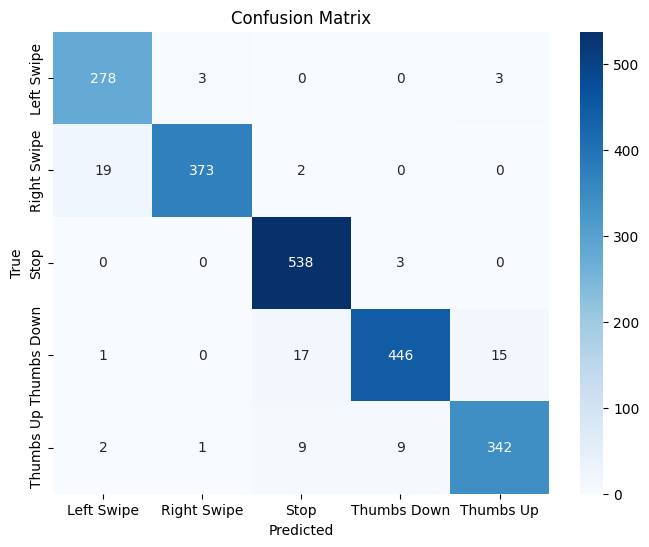

In [ ]:
y_true = df_detected["label"].values
y_pred = df_detected["predicted_label"].values

acc = accuracy_score(y_true, y_pred)
print(f"\nValidation Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Folder-level predictions saved to C:\Users\User\Desktop\Mechatronics_Fundamentals_Project\HandMimic_Dataset_Local\HandMimic_Landmarks_Val\folder_level_predictions.csv

Folder-level Accuracy: 0.9899

Folder-level Classification Report:
              precision    recall  f1-score   support

  Left Swipe       1.00      1.00      1.00        17
 Right Swipe       1.00      1.00      1.00        23
        Stop       1.00      1.00      1.00        22
 Thumbs Down       1.00      0.95      0.98        21
   Thumbs Up       0.94      1.00      0.97        16

    accuracy                           0.99        99
   macro avg       0.99      0.99      0.99        99
weighted avg       0.99      0.99      0.99        99



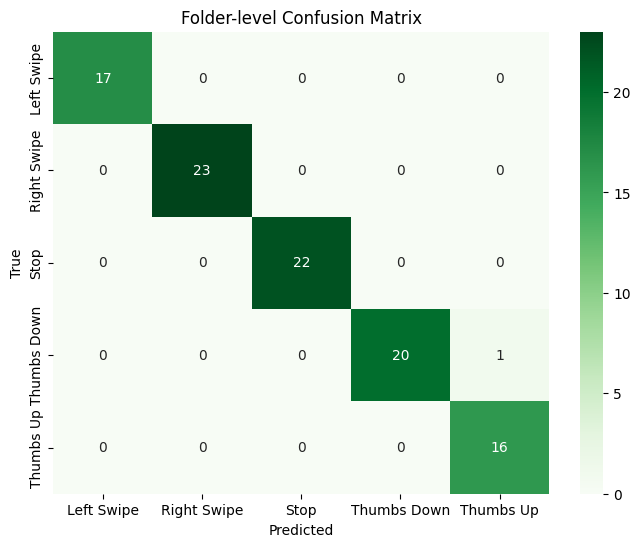

In [ ]:
df_preds = pd.read_csv(val_predictions_csv)

folder_results = []
for folder_name, df_group in df_preds.groupby("folder_name"):
    # majority vote
    voted_label = df_group["predicted_label"].mode()[0]
    confidence_mean = df_group["predicted_confidence"].mean()
    
    # real label (from dataset ground truth)
    true_labels = df_group["label"].dropna().unique()
    true_label = true_labels[0] if len(true_labels) > 0 else None
    
    folder_results.append({
        "folder_name": folder_name,
        "true_label": true_label,
        "voted_label": voted_label,
        "mean_confidence": confidence_mean
    })

df_folder_results = pd.DataFrame(folder_results)
folder_results_csv = MP_OUTPUT_PATH / "folder_level_predictions.csv"
df_folder_results.to_csv(folder_results_csv, index=False)
print(f"Folder-level predictions saved to {folder_results_csv}")

# %%
# Evaluate at folder level
y_true_folders = df_folder_results["true_label"].values
y_pred_folders = df_folder_results["voted_label"].values

acc_folders = accuracy_score(y_true_folders, y_pred_folders)
print(f"\nFolder-level Accuracy: {acc_folders:.4f}")

print("\nFolder-level Classification Report:")
print(classification_report(y_true_folders, y_pred_folders))

cm_folders = confusion_matrix(y_true_folders, y_pred_folders, labels=label_encoder.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm_folders, annot=True, fmt="d", cmap="Greens", 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Folder-level Confusion Matrix")
plt.show()